State Farm Distracted Drivers
=============

Prev Exercises: Udacity:DeepLearning:TensorFlow:notMNIST  

Fit Logistic Regression SGD (TensorFlow)
------------

In [1]:
import sys
print sys.version
import os

import pandas as pd
print 'pd.__version__:%s' % str(pd.__version__)
import tensorflow as tf
print 'tf.__version__:%s' % str(tf.__version__)

2.7.11 (default, Jan 28 2016, 14:07:46) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
pd.__version__:0.18.0
tf.__version__:0.8.0


In [2]:
# These are all the modules we'll be using

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image

from datetime import datetime, time
import math
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
from sklearn import metrics as skmetrics

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

/usr/local/lib/python2.7/site-packages/rpy2/robjects/lib/ggplot2.py:59: UserWarning: This was designed againt ggplot2 version 2.0.0 but you have 2.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


## Analytics Specs

### This Project

In [4]:
%run img_glbSpec_SFDD.py

imported img_glbSpec_SFDD


In [5]:
print '\nglbRspClass: %s' % (glbRspClass)
print 'glbRspClassN: %d' % (glbRspClassN)
print 'glbRspClassDesc: '; print(glbRspClassDesc)

print '\nglbImg:'; print(glbImg)

print '\nglbTfVarSeed: %d' % (glbTfVarSeed)

print '\nglbPickleFile: %s' % (glbPickleFile)


glbRspClass: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
glbRspClassN: 10
glbRspClassDesc: 
{'c9': 'talking to passenger', 'c8': 'hair and makeup', 'c3': 'texting - left', 'c2': 'talking on the phone - right', 'c1': 'texting - right', 'c0': 'normal driving', 'c7': 'reaching behind', 'c6': 'drinking', 'c5': 'operating the radio', 'c4': 'talking on the phone - left'}

glbImg:
{'color': False, 'pxlDepth': 255.0, 'size': 32}

glbTfVarSeed: 131

glbPickleFile: {'models': 'data/img_M_SFDD_ImgSz_32.pickle', 'data': 'data/img_D_SFDD_ImgSz_32.pickle'}


## Import Data

### This Project

In [6]:
with open(glbPickleFile['data'], 'rb') as f:
  save = pickle.load(f)

  glbObsFitIdn = save['glbObsFitIdn']
  glbObsFitFtr = save['glbObsFitFtr']
  glbObsFitRsp = save['glbObsFitRsp']

  glbObsVldIdn = save['glbObsVldIdn']
  glbObsVldFtr = save['glbObsVldFtr']
  glbObsVldRsp = save['glbObsVldRsp']

  glbObsTrnIdn = save['glbObsTrnIdn']
  glbObsTrnFtr = save['glbObsTrnFtr']
  glbObsTrnRsp = save['glbObsTrnRsp']

  glbObsNewIdn = save['glbObsNewIdn']
  glbObsNewFtr = save['glbObsNewFtr']
  glbObsNewRsp = save['glbObsNewRsp']

  del save  # hint to help gc free up memory
    
  print('Fit set:', len(glbObsFitIdn), glbObsFitFtr.shape, glbObsFitRsp.shape)
  print('Vld set:', len(glbObsVldIdn), glbObsVldFtr.shape, glbObsVldRsp.shape)
  print('Trn set:', len(glbObsTrnIdn), glbObsTrnFtr.shape, glbObsTrnRsp.shape)    
  print('New set:', len(glbObsNewIdn), glbObsNewFtr.shape, glbObsNewRsp.shape)

('Fit set:', 17940, (17940, 32, 32), (17940,))
('Vld set:', 4484, (4484, 32, 32), (4484,))
('Trn set:', 22424, (22424, 32, 32), (22424,))
('New set:', 79726, (79726, 32, 32), (79726,))


First reload the data we generated in `1_notmist.ipynb`.

In [7]:
# pickle_file = 'data/notMNIST.pickle'

# with open(pickle_file, 'rb') as f:
#   save = pickle.load(f)
#   glbObsFitFtr = save['glbObsFitFtr']
#   glbObsFitRsp = save['glbObsFitRsp']
#   glbObsVldFtr = save['glbObsVldFtr']
#   glbObsVldRsp = save['glbObsVldRsp']
#   glbObsNewFtr = save['glbObsNewFtr']
#   glbObsNewRsp = save['glbObsNewRsp']
#   del save  # hint to help gc free up memory
#   print('Training set', glbObsFitFtr.shape, glbObsFitRsp.shape)
#   print('Validation set', glbObsVldFtr.shape, glbObsVldRsp.shape)
#   print('Test set', glbObsNewFtr.shape, glbObsNewRsp.shape)

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [8]:
def myreformatData(dataset, labels):
  dataset = dataset.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(glbRspClassN) == labels[:,None]).astype(np.float32)
  return dataset, labels

glbObsTrnFtr, glbObsTrnRsp = myreformatData(glbObsTrnFtr, glbObsTrnRsp)
glbObsFitFtr, glbObsFitRsp = myreformatData(glbObsFitFtr, glbObsFitRsp)
glbObsVldFtr, glbObsVldRsp = myreformatData(glbObsVldFtr, glbObsVldRsp)
glbObsNewFtr, glbObsNewRsp = myreformatData(glbObsNewFtr, glbObsNewRsp)

print('Trn set', glbObsTrnFtr.shape, glbObsTrnRsp.shape)
print('Fit set', glbObsFitFtr.shape, glbObsFitRsp.shape)
print('Vld set', glbObsVldFtr.shape, glbObsVldRsp.shape)
print('New set', glbObsNewFtr.shape, glbObsNewRsp.shape)

('Trn set', (22424, 1024), (22424, 10))
('Fit set', (17940, 1024), (17940, 10))
('Vld set', (4484, 1024), (4484, 10))
('New set', (79726, 1024), (79726, 10))


In [9]:
# glbImg['size'] = 28
# glbRspClassN = 10

# def reformat(dataset, labels):
#   dataset = dataset.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
#   # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
#   labels = (np.arange(glbRspClassN) == labels[:,None]).astype(np.float32)
#   return dataset, labels
# glbObsFitFtr, glbObsFitRsp = reformat(glbObsFitFtr, glbObsFitRsp)
# glbObsVldFtr, glbObsVldRsp = reformat(glbObsVldFtr, glbObsVldRsp)
# glbObsNewFtr, glbObsNewRsp = reformat(glbObsNewFtr, glbObsNewRsp)
# print('Training set', glbObsFitFtr.shape, glbObsFitRsp.shape)
# print('Validation set', glbObsVldFtr.shape, glbObsVldRsp.shape)
# print('Test set', glbObsNewFtr.shape, glbObsNewRsp.shape)

Load previous models, if they exist

In [12]:
try:
    glbMdlDf = pd.read_pickle(glbPickleFile['models'])
except IOError, e:
    print(e)    
    if e.errno == 2:    
        glbMdlDf = pd.DataFrame()
    else:
        raise

#glbMdlDf['id'] = 'LogisticRegression.sklearn'
print(glbMdlDf)

                                                        accVld bstFit  \
id                         nObsFit nObsBtc nStepsTfw                    
LogisticRegression.tf      22424   NaN     20000.0    0.980375  False   
LogisticRegression.sklearn 22424   NaN     NaN        0.983943  False   
LogisticRegression.tf      17940   NaN     20000.0    0.000000   True   
                           10000   NaN     20000.0    0.000000  False   
LogisticRegression.sklearn 17940   NaN     NaN        0.969670  False   
LogisticRegression.tf      17940   NaN     10000.0    0.000000  False   
                           10000   NaN     10000.0    0.000000  False   
LogisticRegression.sklearn 10000   NaN     NaN        0.956512  False   
                           5000    NaN     NaN        0.936664  False   
LogisticRegression.tf      17940   NaN     1000.0     0.000000  False   
                           10000   NaN     1000.0     0.000000  False   
LogisticRegression.sklearn 1000    NaN     NaN     

In [32]:
# tstDf = pd.DataFrame(np.random.randn(5, 3))
# tstDf.columns = ['v0', 'v1', 'v2']
# tstDf.ix[2, 2] = np.nan
# print tstDf

# tstDf['v2'] = tstDf.apply(
#     lambda (row): row['v1'] if pd.isnull(row['v2']) else row['v2'],
#                         axis = 1)

# print 'After'
# print tstDf

         v0        v1        v2
0 -0.528054 -0.055691 -0.211737
1  0.111821  2.059031 -1.749239
2  0.179078  1.028472       NaN
3 -0.124761 -0.728785 -0.712416
4  2.615012  1.990895  0.668994
After
         v0        v1        v2
0 -0.528054 -0.055691 -0.211737
1  0.111821  2.059031 -1.749239
2  0.179078  1.028472  1.028472
3 -0.124761 -0.728785 -0.712416
4  2.615012  1.990895  0.668994


In [67]:
# Initialize columns
# glbMdlDf['nObsBtc'] = np.nan

# Set value based on condition

print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
                                              na=False), 'id']
glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
                                              na=False), 'id'] = 'LgtRgr.SGD.tf'
print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
                                              na=False), 'id']

# glbMdlDf.ix[glbMdlDf['nStepsTfw'].isnull(), 'nStepsTfw'] = 1
# print glbMdlDf['nStepsTfw'].isnull()

# print glbMdlDf['nStepsTfw'].isnull()
# glbMdlDf.ix[glbMdlDf['nStepsTfw'].isnull(), 'nStepsTfw'] = 1
# print glbMdlDf['nStepsTfw'].isnull()

# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]
# glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), 'id'] = 'LogisticRegression.tf'
# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]

# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]
# # glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsBtc'] = \
# #     glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsFit']
# glbMdlDf['nObsBtc'] = glbMdlDf.apply(
#     lambda (row): row['nObsFit'] if pd.isnull(row['nObsBtc']) else row['nObsBtc'],
#                         axis = 1)
# print 'After:'    
# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]

# Remove dups
# print glbMdlDf.columns
# print (glbMdlDf['logLossVld'])
# print (glbMdlDf.index.duplicated())
# tmpMdlDf = glbMdlDf[~glbMdlDf.index.duplicated()]
# print (tmpMdlDf.index.duplicated())
# glbMdlDf = tmpMdlDf

id                         nObsFit  nObsBtc  nStepsTfw
LogisticRegression.SGD.tf  1000     256.0    100.0        LogisticRegression.SGD.tf
                                    128.0    100.0        LogisticRegression.SGD.tf
                                    64.0     100.0        LogisticRegression.SGD.tf
                                    32.0     100.0        LogisticRegression.SGD.tf
                                    256.0    10.0         LogisticRegression.SGD.tf
                                    128.0    10.0         LogisticRegression.SGD.tf
                                    64.0     10.0         LogisticRegression.SGD.tf
                                    32.0     10.0         LogisticRegression.SGD.tf
                           100      16.0     10.0         LogisticRegression.SGD.tf
                           1000     16.0     10.0         LogisticRegression.SGD.tf
                                             100.0        LogisticRegression.SGD.tf
Name: id, dtype: obje

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.


In [68]:
def mydspMdls(lclMdlDf):
    lclMdlDf.ix[lclMdlDf['bstFit'].isnull(), 'bstFit'] = False
    lclMdlDf = (lclMdlDf
                .set_index(['id', 'nObsFit', 'nObsBtc', 'nStepsTfw'], 
                           drop = False)
                .sort_values(['logLossVld', 'accVld'], ascending = 
                             ['True'      , 'False' ])
                )
    print(lclMdlDf)
    return(lclMdlDf)

tmpMdlDf = mydspMdls(glbMdlDf)

                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.tf     22424   22424.0 20000.0    0.980375  False         3533   
LgtRgr.Skl    22424   22424.0 1.0        0.983943  False          238   
LgtRgr.tf     17940   17940.0 20000.0    0.000000   True         2898   
              10000   10000.0 20000.0    0.000000  False         1696   
LgtRgr.Skl    17940   17940.0 1.0        0.969670  False          166   
LgtRgr.tf     17940   17940.0 10000.0    0.000000  False         1411   
              10000   10000.0 10000.0    0.000000  False          801   
LgtRgr.Skl    10000   10000.0 1.0        0.956512  False           83   
              5000    5000.0  1.0        0.936664  False           37   
LgtRgr.tf     17940   17940.0 1000.0     0.000000  False          148   
              10000   10000.0 1000.0     0.000000  False           85   
LgtRgr.Skl    1000    1000.0  1.0        0.836084  

In [69]:
glbMdlDf = mydspMdls(glbMdlDf)

                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.tf     22424   22424.0 20000.0    0.980375  False         3533   
LgtRgr.Skl    22424   22424.0 1.0        0.983943  False          238   
LgtRgr.tf     17940   17940.0 20000.0    0.000000   True         2898   
              10000   10000.0 20000.0    0.000000  False         1696   
LgtRgr.Skl    17940   17940.0 1.0        0.969670  False          166   
LgtRgr.tf     17940   17940.0 10000.0    0.000000  False         1411   
              10000   10000.0 10000.0    0.000000  False          801   
LgtRgr.Skl    10000   10000.0 1.0        0.956512  False           83   
              5000    5000.0  1.0        0.936664  False           37   
LgtRgr.tf     17940   17940.0 1000.0     0.000000  False          148   
              10000   10000.0 1000.0     0.000000  False           85   
LgtRgr.Skl    1000    1000.0  1.0        0.836084  

In [70]:
def mysaveMdls():
    import os
    
    try:
        lclMdlDf = glbMdlDf.drop('model', axis = 1)
    except ValueError, e:
        print(e)
        lclMdlDf = glbMdlDf
    except Exception, e:
        print(e)    
        raise

    try:
        lclMdlDf.to_pickle(glbPickleFile['models'])
    except Exception, e:
        print(e)    
        raise

    print 'Compressed pickle file: %s; size: %d KB'% (glbPickleFile['models'], 
                            os.stat(glbPickleFile['models']).st_size / 1024)
    
mysaveMdls()    

labels ['model'] not contained in axis
Compressed pickle file: data/img_M_SFDD_ImgSz_32.pickle; size: 11 KB


## Fit Logistic Regression (TensorFlow)

Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of sesion.run().

In [65]:
#glbPickleFile

{'data': 'data/img_D_SFDD_ImgSz_32.pickle',
 'models': 'data/img_M_SFDD_ImgSz_32.pickle'}

In [40]:
def mydspVerboseTrigger(ix):
    return(
            ((ix >= 100000) and                   (ix % 200000 == 0)) or \
            ((ix >= 10000 ) and (ix < 100000) and (ix % 20000  == 0)) or \
            ((ix >= 1000  ) and (ix < 10000 ) and (ix % 2000   == 0)) or \
            ((ix >= 100   ) and (ix < 1000  ) and (ix % 200    == 0)) or \
            ((ix >= 10    ) and (ix < 100   ) and (ix % 20     == 0)) or \
            ((ix >= 1     ) and (ix < 10    ) and (ix % 2      == 0)) or \
             (ix ==  0    )
          )

In [78]:
def fitMdlLgtRgrSGDTfw(lclObsFitFtr, lclObsFitRsp, 
                       nObsFit = 50, nObsBtc = 16, nStepsTfw = 11, 
                    verbose = False):
    print('\nLogistic Regression SGD (TensorFlow): ' + 
          'nObsFit:%5d; nObsBtc:%5d; nStepsTfw:%5d' % ( \
            nObsFit, nObsBtc, nStepsTfw))
    
    startTm = datetime.now()

    mdlDf = pd.DataFrame({'id': 'LgtRgr.SGD.tf',
                            'nObsFit'  : [nObsFit],
                            'nObsBtc'  : [nObsBtc],                          
                            'nStepsTfw': [nStepsTfw]
                         })
    
    graph = tf.Graph()
    with graph.as_default():

      # Input data.
      # For the training data, we use a placeholder that will be fed
      #   at run time with a training minibatch.
      tfwObsFitFtr = tf.placeholder(tf.float32,
                    shape = (nObsBtc, glbImg['size'] * glbImg['size']))
      tfwObsFitRsp =tf.placeholder(tf.float32, 
                                   shape = (nObsBtc, glbRspClassN))
    
      # Load the validation and test data into constants that are
      # attached to the graph.
#       tfwObsFitFtr = tf.constant(lclObsFitFtr[:nObsFit, :])
#       tfwObsFitRsp = tf.constant(lclObsFitRsp[:nObsFit])
      tfwObsVldFtr = tf.constant(glbObsVldFtr)
      tfwObsVldRsp = tf.constant(glbObsVldRsp)        
      tfwObsNewFtr = tf.constant(glbObsNewFtr)
      tfwObsNewRsp = tf.constant(glbObsNewRsp)        

      # Variables.
      tf.set_random_seed(glbTfVarSeed)
    
      # These are the parameters that we are going to be training. The weight
      # matrix will be initialized using random valued following a (truncated)
      # normal distribution. The biases get initialized to zero.
      weights = tf.Variable(
        tf.truncated_normal([glbImg['size'] * glbImg['size'], glbRspClassN]), 
        name = 'weights')
      biases = tf.Variable(tf.zeros([glbRspClassN]), name = 'biases')
      if (verbose):  
          print '  weights:'; print(weights.initialized_value())
          print '   biases:'; print(biases.initialized_value())
    #     print 'lblIx:%2d:%s'% (np.vectorize("%.4e".__mod__)(weights.value()[:5, lblIx]))

      # Training computation.
      # We multiply the inputs with the weight matrix, and add biases. We compute
      # the softmax and cross-entropy (it's one operation in TensorFlow, because
      # it's very common, and it can be optimized). We take the average of this
      # cross-entropy across all training examples: that's our loss.
      logits = tf.matmul(tfwObsFitFtr, weights) + biases
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))

      # Optimizer.
      # We are going to find the minimum of this loss using gradient descent.
      optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

      # Predictions for the training, validation, and test data.
      # These are not part of training, but merely here so that we can report
      # accuracy_score figures as we train.
      tfwObsFitRspPredProba = tf.nn.softmax(logits)
      tfwObsVldRspPredProba = tf.nn.softmax(tf.matmul(tfwObsVldFtr, weights) + 
                                            biases)
      tfwObsNewRspPredProba = tf.nn.softmax(tf.matmul(tfwObsNewFtr, weights) + 
                                            biases)
    
    def accuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
              / predictions.shape[0])

    with tf.Session(graph=graph) as session:
      # This is a one-time operation which ensures the parameters get initialized as
      # we described in the graph: random weights for the matrix, zeros for the
      # biases. 
      tf.initialize_all_variables().run()
      if verbose:
          print('  initialized')
        
      for step in range(nStepsTfw):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * nObsBtc) % (nObsFit - nObsBtc)
        # Generate a minibatch.
        btcObsFitFtr = lclObsFitFtr[offset:(offset + nObsBtc), :]
        btcObsFitRsp = lclObsFitRsp[offset:(offset + nObsBtc), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfwObsFitFtr : btcObsFitFtr, tfwObsFitRsp : btcObsFitRsp}        
        
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run(
            [optimizer, loss, tfwObsFitRspPredProba], feed_dict = feed_dict)
        if mydspVerboseTrigger(step):
          accBtc = accuracy_score(predictions, 
                                  btcObsFitRsp[:nObsFit, :])  
          print '  step %5d: (%5d secs) Minibatch accrcy: %.4f; logLoss: %.4f' % \
                (step, (datetime.now() - startTm).seconds, accBtc, l)
        
#       print '  predictions:'; 
#       print type(predictions); 
#       print predictions.shape; 
#       print predictions[:6, :]
# #       print '  tfwObsFitRspPredProba.eval():'; 
# #       print type(tfwObsFitRspPredProba.eval()); 
# #       print tfwObsFitRspPredProba.eval().shape; 
# #       print tfwObsFitRspPredProba.eval()[:6, :]
#       print '  tfwObsFitRsp.eval():'; 
#       print type(tfwObsFitRsp.eval()); print tfwObsFitRsp.get_shape(); 
#       print tfwObsFitRsp.eval()[:6, :]
#       accFit = accuracy_score(tfwObsFitRspPredProba.eval(), 
#                               tfwObsFitRsp.eval()[:nObsFit, :])
#       logLossFit = skmetrics.log_loss(tfwObsFitRsp.eval()[:nObsFit, :], 
#                                                     tfwObsFitRspPredProba.eval())    
#       print 'accFit:%.4f; logLossFit:%.4f' % (accFit, logLossFit)    

          # Calling .eval() on tfwObsVldPred is basically like calling run(), but
          # just to get that one numpy array. Note that it recomputes all its graph
          # dependencies.

#       nChkObs = 100        
#       print 'nChkObs: %d' % (nChkObs)
#       print 'tfwObsVldRspPredProba.eval():'  
#       print np.array_str(tfwObsVldRspPredProba.eval()[:nChkObs, :], 
#                          precision=4, suppress_small=True)
#       print 'tfwObsVldRsp.eval():'  
#       print tfwObsVldRsp.eval()[:nChkObs, :]    
#       print 'accuracy comparisons:'  
#       print (np.argmax(tfwObsVldRspPredProba.eval(), 1) == 
#              np.argmax(tfwObsVldRsp.eval(), 1))[:nChkObs]
#       print 1.0 * np.sum((np.argmax(tfwObsVldRspPredProba.eval(), 1) == 
#              np.argmax(tfwObsVldRsp.eval(), 1))[:nChkObs]) / nChkObs
      mdlDf['accVld'] = accVld = accuracy_score(tfwObsVldRspPredProba.eval(), 
                                                    tfwObsVldRsp.eval())
      mdlDf['logLossVld'] = logLossVld = skmetrics.log_loss(tfwObsVldRsp.eval(), 
                                                    tfwObsVldRspPredProba.eval())    
      print '  accVld: %.4f; logLossVld: %.4f' % (accVld, logLossVld)
            
      lclObsNewRspPredProba = tfwObsNewRspPredProba.eval()  
      #if (tfwObsNewRsp.eval() > -1).any():
      if (len(np.unique(tfwObsNewRsp.eval(), return_counts = True)[0]) > 1):        
          if verbose:      
              print('  accNew: %.4f' % 
                    accuracy_score(tfwObsNewRspPredProba.eval(), tfwObsNewRsp.eval()))

      clsKntDct = {'clsKnt' : np.unique(np.argmax(tfwObsNewRspPredProba.eval(), 1), 
                                        return_counts = True)}
      mdlDf['predNew'] = None
      mdlDf.set_value(0, 'predNew', clsKntDct)
      #print type(clsKntDct)
      if verbose:
          print '\n  New prediction knts:'
          print mdlDf['predNew'][0]
            
    mdlDf['model'] = graph
    mdlDf['elapsedSecs'] = (datetime.now() - startTm).seconds  
    print('  elapsed: %.2d seconds' % (mdlDf['elapsedSecs'][0]))  
    
    return(mdlDf, lclObsNewRspPredProba)

mdlDf = pd.DataFrame()
thsDf, thsObsNewRspPredProba = fitMdlLgtRgrSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                        nObsFit = 100, nObsBtc = 16, nStepsTfw = 10, 
                        verbose = True)
print 'thsObsNewRspPredProba:'  
print np.array_str(thsObsNewRspPredProba[:6, :], 
                         precision=4, suppress_small=True)

mdlDf = mdlDf.append(thsDf)
thsDf, _                     = fitMdlLgtRgrSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                        nObsFit = 100, nObsBtc = 16, nStepsTfw = 10, 
                        verbose = False)
mdlDf = mdlDf.append(thsDf)

# mdlDf = mdlDf.append(fitMdlLgtRgrTfw(glbObsFitFtr, glbObsFitRsp, 
#                         nObsFit = 100, nStepsTfw = 100, 
#                         verbose = False))
# mdlDf = mdlDf.append(fitMdlLgtRgrTfw(glbObsFitFtr, glbObsFitRsp, 
#                         nObsFit = 100, nStepsTfw = 1000, 
#                         verbose = True))
# mdlDf = mdlDf.append(fitMdlLgtRgrTfw(glbObsFitFtr, glbObsFitRsp, 
#                         nObsFit = 100, nStepsTfw = 10000, 
#                         verbose = False))
print '\nmdlDf: '
print(mdlDf)

tmpMdlDf = glbMdlDf.append(mdlDf)
print tmpMdlDf.tail()


Logistic Regression SGD (TensorFlow): nObsFit:  100; nObsBtc:   16; nStepsTfw:   10
  weights:
Tensor("Identity:0", shape=(1024, 10), dtype=float32)
   biases:
Tensor("Identity_1:0", shape=(10,), dtype=float32)
  initialized
  step     0: (    2 secs) Minibatch accrcy: 0.0625; logLoss: 13.1753
  step     2: (    2 secs) Minibatch accrcy: 0.0000; logLoss: 9.7903
  step     4: (    2 secs) Minibatch accrcy: 0.1250; logLoss: 7.3177
  step     6: (    2 secs) Minibatch accrcy: 0.1875; logLoss: 7.6751
  step     8: (    2 secs) Minibatch accrcy: 0.0625; logLoss: 7.7043
  accVld: 0.1224; logLossVld: 7.1309

  New prediction knts:
{'clsKnt': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([18999, 15120,  9692,  2123, 10032,  4968,  5716,   140, 12888,    48]))}
  elapsed: 05 seconds
thsObsNewRspPredProba:
[[ 0.      0.      0.007   0.      0.      0.9803  0.      0.      0.0127
   0.    ]
 [ 0.      0.      0.006   0.      0.671   0.1576  0.1572  0.      0.0081
   0.    ]
 [ 0.0833  0.0001  0.

In [135]:
nObsFitSearch = [glbObsFitFtr.shape[0]]
# nObsFitSearch = [100, 1000, 10000, glbObsFitFtr.shape[0]]
nObsBtcSearch = [int(2 ** ix) for ix in [9, 9.25, 9.5]]
# nObsBtcSearch = [int(2 ** ix) for ix in [8, 9, 9.5, 10]]
nStepsTfwSearch = [30000]
# nStepsTfwSearch = [100, 1000, 10000, 20000, 30000]

def mysearchModelParams(mode = 'displayonly'):
    retMdlDf = glbMdlDf
    
    for nObsFit in nObsFitSearch:
        for nObsBtc in nObsBtcSearch:
            for nStepsTfw in nStepsTfwSearch:
                if (glbMdlDf.shape[0] == 0) or \
                   (glbMdlDf[
                            (glbMdlDf.nObsFit   == nObsFit  ) &
                            (glbMdlDf.nObsBtc   == nObsBtc  ) &                        
                            (glbMdlDf.nStepsTfw == nStepsTfw)
                            ].shape[0] == 0):
                    if (mode == 'displayonly'):
                        print 'Running fitMdlLgtRgrSGDTfw with params:' + \
                        ' nObsFit: %5d nObsBtc: %5d nStepsTfw: %5d' % \
                            (nObsFit, nObsBtc, nStepsTfw)
                    else:        
                        thsMdlDf, _ = fitMdlLgtRgrSGDTfw(glbObsFitFtr, glbObsFitRsp, 
                            nObsFit, nObsBtc, nStepsTfw, 
                            verbose = False)
                        retMdlDf = retMdlDf.append(thsMdlDf)  
                    
    if (mode == 'displayonly'):
        return(None)
    else:
        return(retMdlDf)
    
mysearchModelParams(mode = 'displayonly')    

Running fitMdlLgtRgrSGDTfw with params: nObsFit: 17940 nObsBtc:   512 nStepsTfw: 30000
Running fitMdlLgtRgrSGDTfw with params: nObsFit: 17940 nObsBtc:   608 nStepsTfw: 30000
Running fitMdlLgtRgrSGDTfw with params: nObsFit: 17940 nObsBtc:   724 nStepsTfw: 30000


In [136]:
# tmpMdlDf = mysearchModelParams(mode = 'run')
# tmpMdlDf = glbMdlDf.append(tmpMdlDf)
# print tmpMdlDf.tail()

glbMdlDf = mysearchModelParams(mode = 'run')
print glbMdlDf.tail()


Logistic Regression SGD (TensorFlow): nObsFit:17940; nObsBtc:  512; nStepsTfw:30000
  step     0: (    2 secs) Minibatch accrcy: 0.1309; logLoss: 10.8389
  step     2: (    2 secs) Minibatch accrcy: 0.1152; logLoss: 7.3434
  step     4: (    3 secs) Minibatch accrcy: 0.1504; logLoss: 5.8804
  step     6: (    3 secs) Minibatch accrcy: 0.1211; logLoss: 5.8083
  step     8: (    3 secs) Minibatch accrcy: 0.1602; logLoss: 4.9679
  step    20: (    3 secs) Minibatch accrcy: 0.1855; logLoss: 4.3952
  step    40: (    3 secs) Minibatch accrcy: 0.2305; logLoss: 3.8108
  step    60: (    4 secs) Minibatch accrcy: 0.2793; logLoss: 3.1939
  step    80: (    4 secs) Minibatch accrcy: 0.2539; logLoss: 3.3097
  step   200: (    6 secs) Minibatch accrcy: 0.3867; logLoss: 2.2509
  step   400: (   10 secs) Minibatch accrcy: 0.5918; logLoss: 1.4853
  step   600: (   13 secs) Minibatch accrcy: 0.6133; logLoss: 1.1915
  step   800: (   17 secs) Minibatch accrcy: 0.7422; logLoss: 0.8153
  step  2000: (  

In [137]:
#glbMdlDf = glbMdlDf.append(mdlDf)
glbMdlDf = mydspMdls(glbMdlDf)

                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.tf     22424   22424.0 20000.0    0.980375  False         3533   
LgtRgr.SGD.tf 17940   608.0   30000.0    0.966102  False          526   
                      512.0   30000.0    0.965656  False          536   
                      724.0   30000.0    0.966548  False          564   
LgtRgr.Skl    22424   22424.0 1.0        0.983943  False          238   
LgtRgr.tf     17940   17940.0 20000.0    0.000000   True         2898   
LgtRgr.SGD.tf 17940   724.0   20000.0    0.960749  False          390   
                      512.0   20000.0    0.959188  False          341   
                      256.0   20000.0    0.958519  False          301   
                      1024.0  20000.0    0.958073  False          509   
LgtRgr.tf     10000   10000.0 20000.0    0.000000  False         1696   
LgtRgr.Skl    17940   17940.0 1.0        0.969670  

In [138]:
logLossVldBst = np.min(glbMdlDf[glbMdlDf['nObsFit'] <= 
                                glbObsFitFtr.shape[0]]['logLossVld'])
# print logLossVldBst
glbMdlDf['bstFit'] = False
# print(glbMdlDf['logLossVld'] == logLossVldBst)
glbMdlDf.ix[glbMdlDf['logLossVld'] == logLossVldBst, 'bstFit'] = True
# print glbMdlDf
print 'Selected Model:'
print glbMdlDf[glbMdlDf['bstFit'] == True]

Selected Model:
                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.SGD.tf 17940   608.0   30000.0    0.966102   True          526   

                                                    id  logLossVld  \
id            nObsFit nObsBtc nStepsTfw                              
LgtRgr.SGD.tf 17940   608.0   30000.0    LgtRgr.SGD.tf    0.137941   

                                                                                     model  \
id            nObsFit nObsBtc nStepsTfw                                                      
LgtRgr.SGD.tf 17940   608.0   30000.0    <tensorflow.python.framework.ops.Graph object ...   

                                         nObsBtc  nObsFit nStepsTfw  \
id            nObsFit nObsBtc nStepsTfw                               
LgtRgr.SGD.tf 17940   608.0   30000.0      608.0    17940     30000   

                                                        

In [139]:
mysaveMdls()

Compressed pickle file: data/img_M_SFDD_ImgSz_32.pickle; size: 16 KB


In [151]:
robjects.pandas2ri.activate()
glbMdlRDf = robjects.conversion.py2ri(glbMdlDf)
print(glbMdlRDf)

                                             accVld bstFit elapsedSecs
('LgtRgr.SGD.tf', 22424, 608.0, 30000.0)  0.9875112  False         517
('LgtRgr.tf', 22424, 22424.0, 20000.0)    0.9803747  False        3533
('LgtRgr.SGD.tf', 17940, 608.0, 30000.0)  0.9661017   True         526
('LgtRgr.SGD.tf', 17940, 512.0, 30000.0)  0.9656557  False         536
('LgtRgr.SGD.tf', 17940, 724.0, 30000.0)  0.9665477  False         564
('LgtRgr.Skl', 22424, 22424.0, 1.0)       0.9839429  False         238
('LgtRgr.tf', 17940, 17940.0, 20000.0)    0.0000000  False        2898
('LgtRgr.SGD.tf', 17940, 724.0, 20000.0)  0.9607493  False         390
('LgtRgr.SGD.tf', 17940, 512.0, 20000.0)  0.9591882  False         341
('LgtRgr.SGD.tf', 17940, 256.0, 20000.0)  0.9585192  False         301
('LgtRgr.SGD.tf', 17940, 1024.0, 20000.0) 0.9580731  False         509
('LgtRgr.tf', 10000, 10000.0, 20000.0)    0.0000000  False        1696
('LgtRgr.Skl', 17940, 17940.0, 1.0)       0.9696699  False         166
('LgtR

In [152]:
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf) {
        mypltModelStats(RDf, c('accVld', 'logLossVld', 'elapsedSecs'), 
            dim = c('nObsFit','id', 'nObsBtc', 'nStepsTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bstFit == 'TRUE'),                
            title = NULL, 
            fileName = 'img_04_fit_lgtRgrSGDTf_SFDD_MdlStats.png')
    }                        
""")    
pltRFn(glbMdlRDf)

<ListVector - Python:0x11bc0e3b0 / R:0x7fae7a1f2608>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x11bc0e3b0 / R:0x7fae7a1f2608>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x11bc0e3b0 / R:0x7fae7a1f2608>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11bc0e3f8 / R:0x7faea67a3310>
  ...
<ListVector - Python:0x11bc0e3b0 / R:0x7fae7a1f2608>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11bc123f8 / R:0x7fae788f10b0>
<ListVector - Python:0x11bc0e3b0 / R:0x7fae7a1f2608>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [153]:
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld'), 
            dim = c('nObsFit','id', 'nObsBtc', 'nStepsTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bstFit == 'TRUE'),
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(glbMdlRDf, 'img_04_fit_lgtRgrSGDTf_SFDD_MdlAccrcy.png')

<ListVector - Python:0x11bc12998 / R:0x7faea6680f48>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x11bc12998 / R:0x7faea6680f48>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x11bc12998 / R:0x7faea6680f48>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11d0eb2d8 / R:0x7fae78c7c540>
  ...
<ListVector - Python:0x11bc12998 / R:0x7faea6680f48>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x11d0eb5a8 / R:0x7fae78d86c68>
<ListVector - Python:0x11bc12998 / R:0x7faea6680f48>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [154]:
# print type(glbMdlRDf)
nObsFitChk = glbObsFitFtr.shape[0]
tmpMdlRDf = robjects.conversion.py2ri(glbMdlDf[glbMdlDf['nObsFit'] == nObsFitChk])
# print tmpMdlRDf
print(glbMdlDf[glbMdlDf['nObsFit'] == nObsFitChk]\
      [['logLossVld', 'elapsedSecs']].sort(['logLossVld', 'elapsedSecs'],
                               ascending = [True,         False]))
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld'), 
            dim = c('nObsBtc', 'id', 'nStepsTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bstFit == 'TRUE'),
            title = NULL, 
            fileName = filename)
    }
""")    
pltRFn(tmpMdlRDf, 'img_04_fit_lgtRgrSGDTf_SFDD_MdlAccrcy_nObsFit_' + 
                   str(nObsFitChk) + '.png')
savRFn = robjects.r("""
    function(RDf, filename) {
        save(RDf, file = filename)            
    }    
""")    
savRFn(tmpMdlRDf, 'img_04_fit_lgtRgrSGDTf_SFDD_MdlAccrcy_nObsFit_' + 
                   str(nObsFitChk) + '.RData')

                                         logLossVld  elapsedSecs
id            nObsFit nObsBtc nStepsTfw                         
LgtRgr.SGD.tf 17940   608.0   30000.0      0.137941          526
                      512.0   30000.0      0.138595          536
                      724.0   30000.0      0.138783          564
LgtRgr.tf     17940   17940.0 20000.0      0.160944         2898
LgtRgr.SGD.tf 17940   724.0   20000.0      0.162354          390
                      512.0   20000.0      0.162648          341
                      256.0   20000.0      0.163018          301
                      1024.0  20000.0      0.163696          509
LgtRgr.Skl    17940   17940.0 1.0          0.201309          166
LgtRgr.tf     17940   17940.0 10000.0      0.217923         1411
LgtRgr.SGD.tf 17940   512.0   10000.0      0.217970          173
                      1024.0  10000.0      0.219008          244
                      724.0   10000.0      0.219062          191
                      256

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


rpy2.rinterface.NULL

In [72]:
# raw_data = {'first_name': ['Jason', 'Jason', 'Tina', 'Jake', 'Amy'], 
#         'last_name': ['Miller', 'Miller', 'Ali', 'Milner', 'Cooze'], 
#         'age': [42, 42, 36, 24, 73], 
#         'preTestScore': [4, 4, 31, 2, 3],
#         'postTestScore': [25, 25, 57, 62, 70]}
# df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'preTestScore', 'postTestScore'])
# print df.duplicated()

0    False
1     True
2    False
3    False
4    False
dtype: bool


### Fit selected model to glbObsFit

In [144]:
selMdlSrs = glbMdlDf[glbMdlDf['bstFit']]
print selMdlSrs

                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.SGD.tf 17940   608.0   30000.0    0.966102   True          526   

                                                    id  logLossVld  \
id            nObsFit nObsBtc nStepsTfw                              
LgtRgr.SGD.tf 17940   608.0   30000.0    LgtRgr.SGD.tf    0.137941   

                                                                                     model  \
id            nObsFit nObsBtc nStepsTfw                                                      
LgtRgr.SGD.tf 17940   608.0   30000.0    <tensorflow.python.framework.ops.Graph object ...   

                                         nObsBtc  nObsFit nStepsTfw  \
id            nObsFit nObsBtc nStepsTfw                               
LgtRgr.SGD.tf 17940   608.0   30000.0      608.0    17940     30000   

                                                                        

In [145]:
finMdlDf, glbObsNewRspPredProba = fitMdlLgtRgrSGDTfw(glbObsTrnFtr, glbObsTrnRsp, 
                        nObsFit = glbObsTrnFtr.shape[0], 
                        nObsBtc = selMdlSrs['nObsBtc'][0],                              
                        nStepsTfw = selMdlSrs['nStepsTfw'][0], 
                     verbose = True)
# thsDf, thsObsNewRspPredProba = fitMdlLgtRgrTfw(glbObsFitFtr, glbObsFitRsp, 
#                         nObsFit = 100, nStepsTfw = 10, 
#                         verbose = True)


Logistic Regression SGD (TensorFlow): nObsFit:22424; nObsBtc:  608; nStepsTfw:30000
  weights:
Tensor("Identity:0", shape=(1024, 10), dtype=float32)
   biases:
Tensor("Identity_1:0", shape=(10,), dtype=float32)
  initialized
  step     0: (    2 secs) Minibatch accrcy: 0.1382; logLoss: 10.9765
  step     2: (    2 secs) Minibatch accrcy: 0.1118; logLoss: 6.6010
  step     4: (    2 secs) Minibatch accrcy: 0.1283; logLoss: 6.0252
  step     6: (    2 secs) Minibatch accrcy: 0.1382; logLoss: 5.6195
  step     8: (    2 secs) Minibatch accrcy: 0.1299; logLoss: 5.7435
  step    20: (    3 secs) Minibatch accrcy: 0.1809; logLoss: 4.8326
  step    40: (    5 secs) Minibatch accrcy: 0.2237; logLoss: 3.6679
  step    60: (    5 secs) Minibatch accrcy: 0.2911; logLoss: 3.6190
  step    80: (    6 secs) Minibatch accrcy: 0.3109; logLoss: 2.8405
  step   200: (    8 secs) Minibatch accrcy: 0.4030; logLoss: 2.1638
  step   400: (   11 secs) Minibatch accrcy: 0.5461; logLoss: 1.4776
  step   600: 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [146]:
print finMdlDf
#print finMdlDf['nStepsTfw']

              id  nObsBtc  nObsFit  nStepsTfw    accVld  logLossVld  \
0  LgtRgr.SGD.tf    608.0    22424      30000  0.987511    0.076897   

                                             predNew  \
0  {u'clsKnt': ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [...   

                                               model  elapsedSecs  
0  <tensorflow.python.framework.ops.Graph object ...          517  


In [148]:
glbMdlDf = glbMdlDf.append(finMdlDf)

In [149]:
glbMdlDf = mydspMdls(glbMdlDf)

                                           accVld bstFit  elapsedSecs  \
id            nObsFit nObsBtc nStepsTfw                                 
LgtRgr.SGD.tf 22424   608.0   30000.0    0.987511  False          517   
LgtRgr.tf     22424   22424.0 20000.0    0.980375  False         3533   
LgtRgr.SGD.tf 17940   608.0   30000.0    0.966102   True          526   
                      512.0   30000.0    0.965656  False          536   
                      724.0   30000.0    0.966548  False          564   
LgtRgr.Skl    22424   22424.0 1.0        0.983943  False          238   
LgtRgr.tf     17940   17940.0 20000.0    0.000000  False         2898   
LgtRgr.SGD.tf 17940   724.0   20000.0    0.960749  False          390   
                      512.0   20000.0    0.959188  False          341   
                      256.0   20000.0    0.958519  False          301   
                      1024.0  20000.0    0.958073  False          509   
LgtRgr.tf     10000   10000.0 20000.0    0.000000  

In [150]:
mysaveMdls()

Compressed pickle file: data/img_M_SFDD_ImgSz_32.pickle; size: 16 KB


Generate the model plots by scrolling up

### Predict ObsNew using finMdlDf['model'] 

In [155]:
# print np.array_str(glbObsNewRspPredProba[:5, :], 
#                    precision = 4, suppress_small = True)
glbObsNewRspPred = np.argmax(glbObsNewRspPredProba, axis = 1)
# print glbObsNewRspPred[:5]
print np.unique(glbObsNewRspPred, return_counts = True)
#print glbObsTrnRsp[:5, :]
tmpObsTrnRsp = np.argmax(glbObsTrnRsp, axis = 1)
# print tmpObsTrnRsp[:5]
print np.unique(glbObsNewRspPred, return_counts = True)[1] * 1.0 / \
      np.unique(tmpObsTrnRsp, return_counts = True)[1]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 6233, 10447,  8158,  7403,  6110,  7757,  6023,  7560, 13766,  6269]))
[ 2.50421856  4.6082929   3.52093224  3.15558397  2.62682717  3.35510381
  2.59053763  3.77622378  7.20355835  2.94457492]




Max Proba for cls: c0; desc: normal driving; proba: 1.0000; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_22281.jpg:


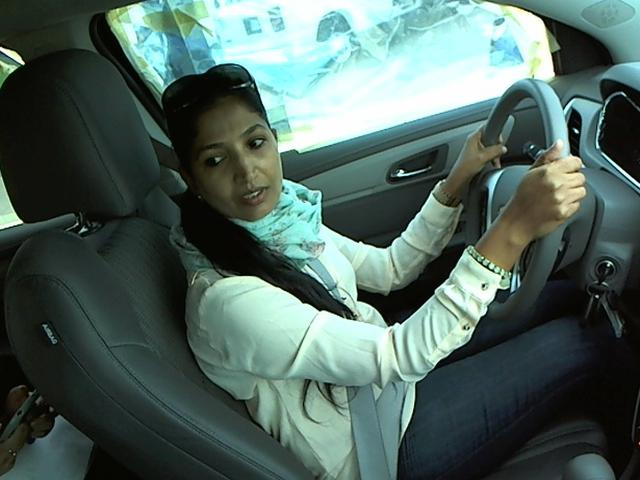

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c0; desc: normal driving; proba: 0.2393; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_13086.jpg:


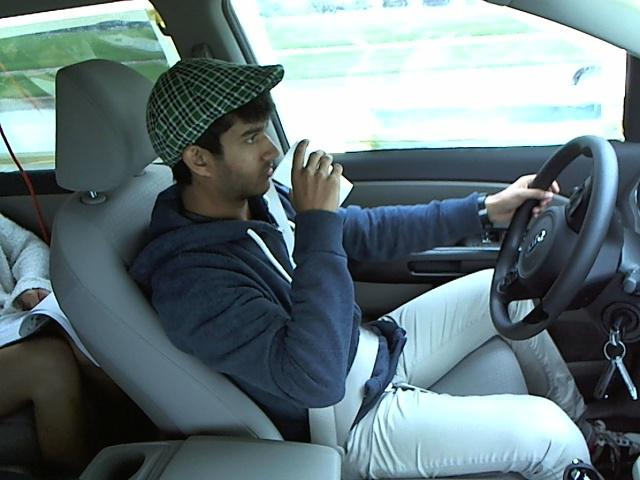

  Proba:
[ 0.2393  0.187   0.0726  0.1583  0.001   0.      0.1746  0.0988  0.0297
  0.0389]
  next best class: texting - right


Max Proba for cls: c1; desc: texting - right; proba: 1.0000; nObsNew: 2
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_3223.jpg:


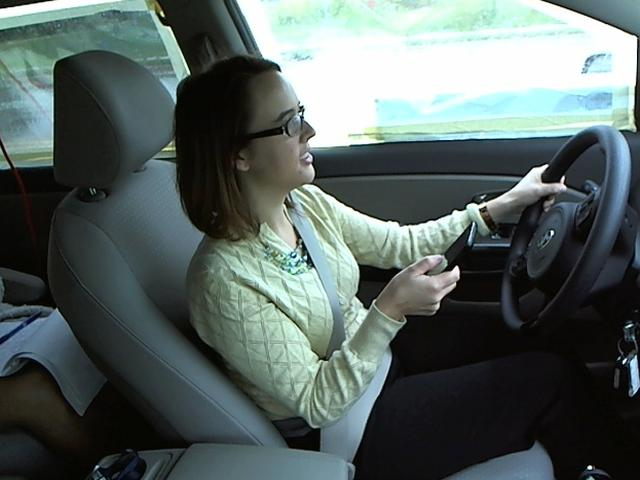

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c1; desc: texting - right; proba: 0.2390; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_39955.jpg:


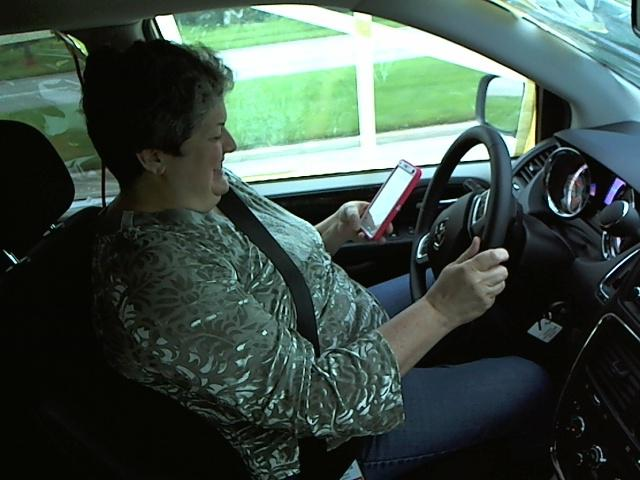

  Proba:
[ 0.0976  0.239   0.0052  0.2232  0.002   0.0161  0.1612  0.0146  0.0256
  0.2153]
  next best class: texting - left


Max Proba for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_45248.jpg:


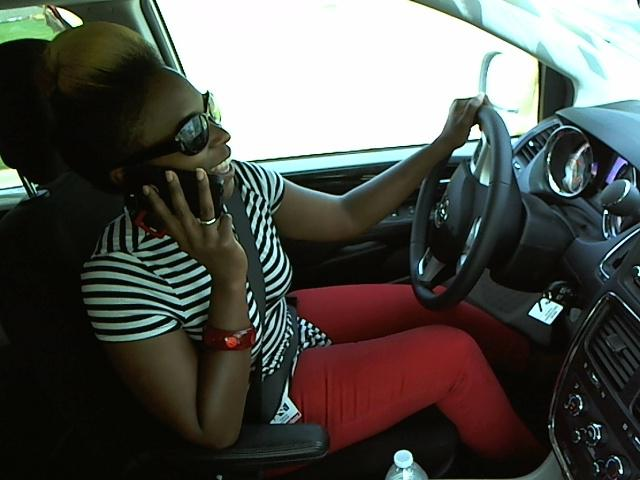

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c2; desc: talking on the phone - right; proba: 0.2022; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_84684.jpg:


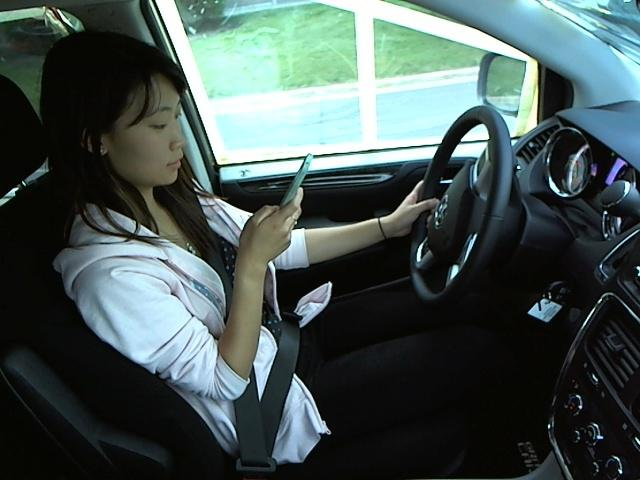

  Proba:
[ 0.      0.184   0.2022  0.1561  0.0001  0.0009  0.1027  0.1977  0.1392
  0.0173]
  next best class: reaching behind


Max Proba for cls: c3; desc: texting - left; proba: 1.0000; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_56747.jpg:


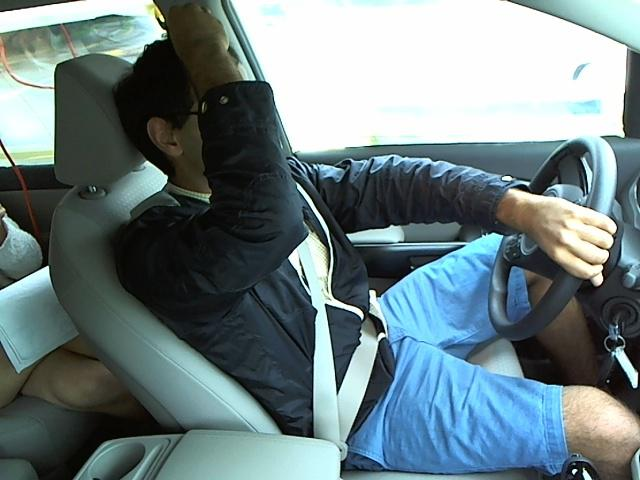

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Min Proba for cls: c3; desc: texting - left; proba: 0.2487; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_77578.jpg:


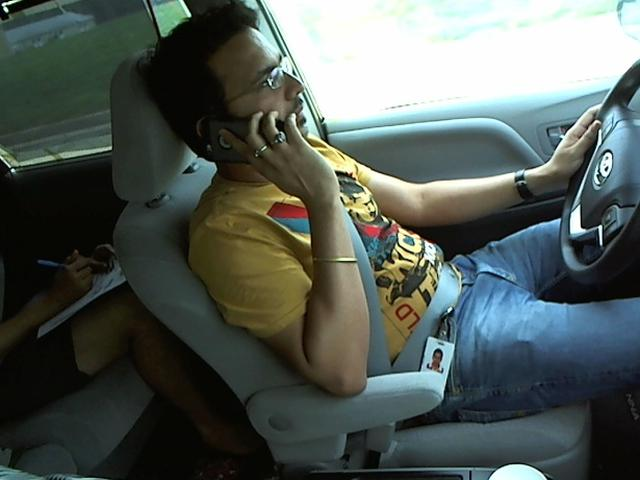

  Proba:
[ 0.2477  0.1706  0.0682  0.2487  0.0022  0.0278  0.0214  0.0035  0.1935
  0.0164]
  next best class: normal driving


Max Proba for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_40761.jpg:


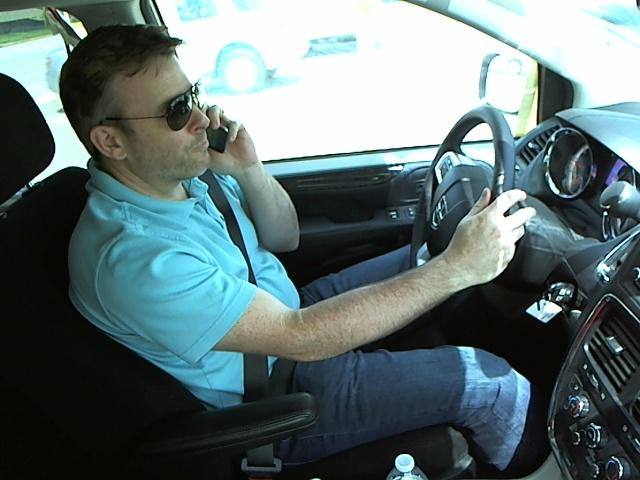

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Min Proba for cls: c4; desc: talking on the phone - left; proba: 0.2326; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_82449.jpg:


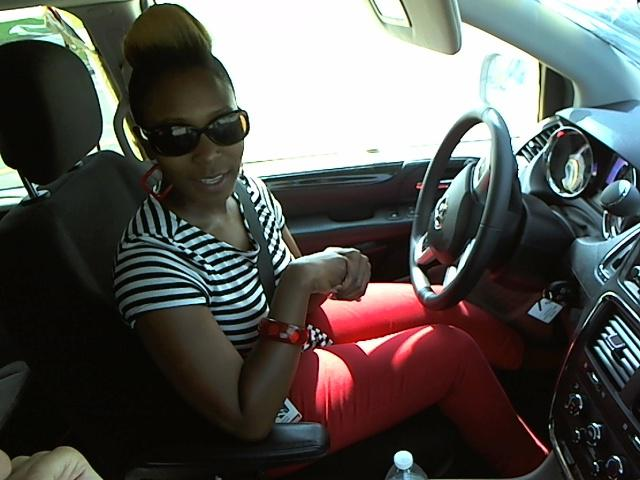

  Proba:
[ 0.1303  0.1603  0.2161  0.0006  0.2326  0.0476  0.0035  0.0002  0.1931
  0.0156]
  next best class: talking on the phone - right


Max Proba for cls: c5; desc: operating the radio; proba: 1.0000; nObsNew: 169
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100652.jpg:


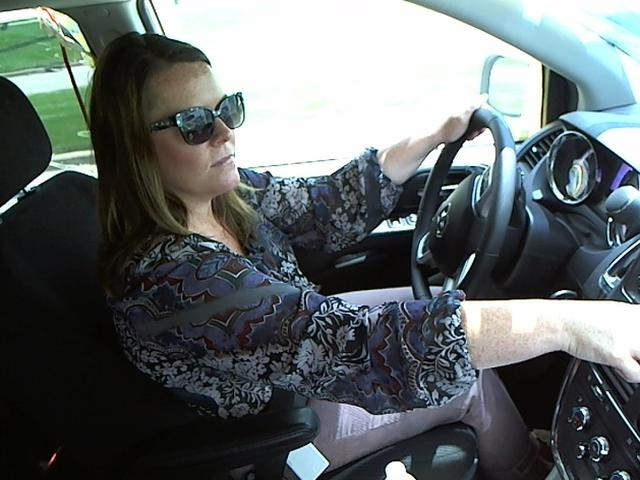

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Min Proba for cls: c5; desc: operating the radio; proba: 0.2623; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_46236.jpg:


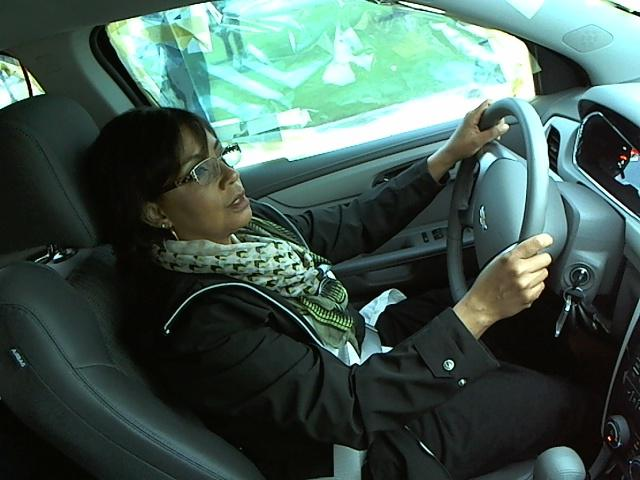

  Proba:
[ 0.1121  0.      0.2496  0.0157  0.0875  0.2623  0.0558  0.1424  0.0002
  0.0743]
  next best class: talking on the phone - right


Max Proba for cls: c6; desc: drinking; proba: 1.0000; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_89962.jpg:


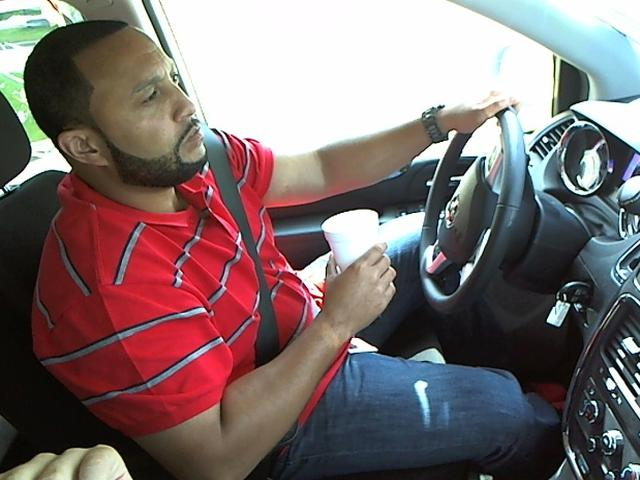

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Min Proba for cls: c6; desc: drinking; proba: 0.2178; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_50917.jpg:


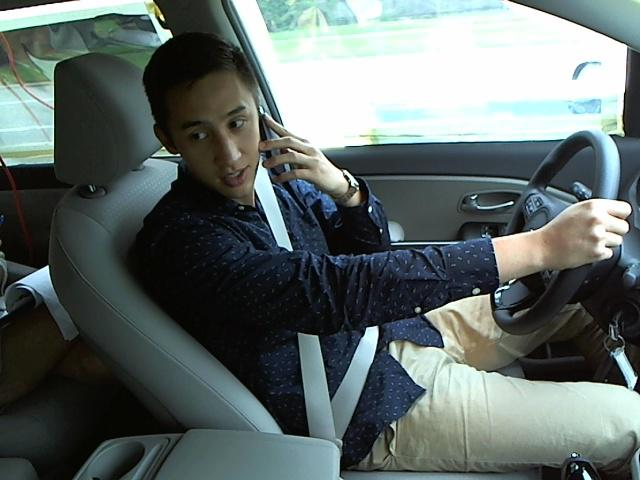

  Proba:
[ 0.0017  0.1534  0.2083  0.1933  0.0159  0.192   0.2178  0.      0.0057
  0.012 ]
  next best class: talking on the phone - right


Max Proba for cls: c7; desc: reaching behind; proba: 1.0000; nObsNew: 54
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_100132.jpg:


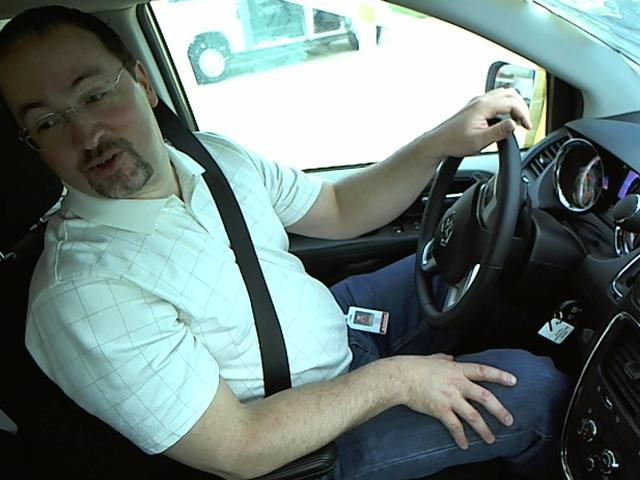

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
Min Proba for cls: c7; desc: reaching behind; proba: 0.2271; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_11389.jpg:


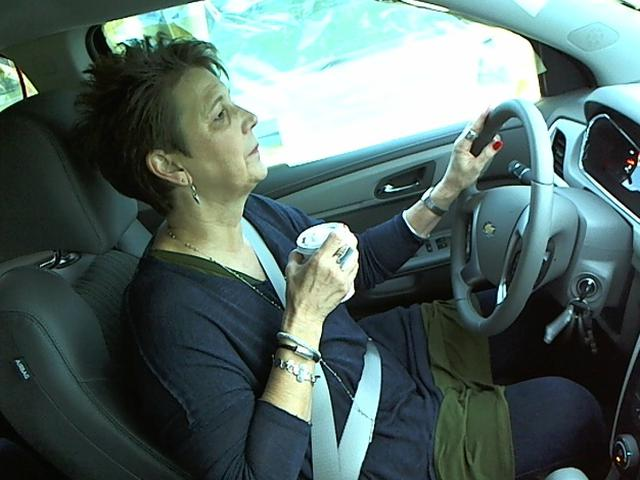

  Proba:
[ 0.1175  0.0005  0.1553  0.0583  0.1274  0.0004  0.036   0.2271  0.1838
  0.0937]
  next best class: hair and makeup


Max Proba for cls: c8; desc: hair and makeup; proba: 1.0000; nObsNew: 4
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_39070.jpg:


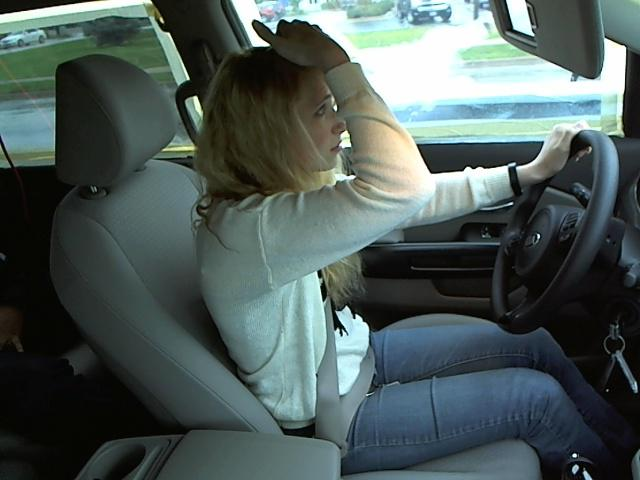

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Min Proba for cls: c8; desc: hair and makeup; proba: 0.2209; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_35840.jpg:


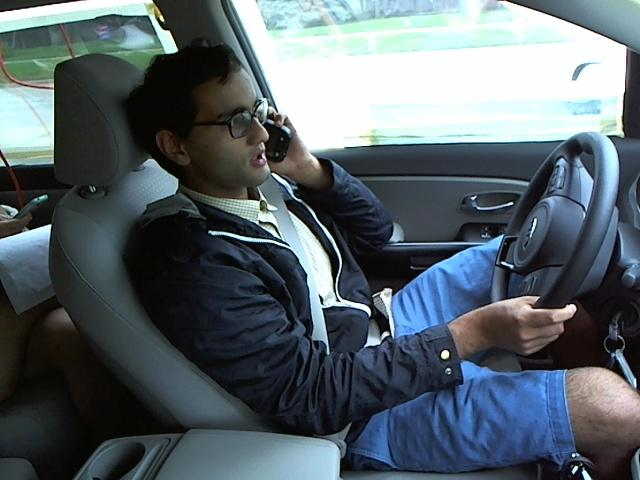

  Proba:
[ 0.0013  0.2088  0.0952  0.1308  0.0104  0.1779  0.1547  0.      0.2209
  0.    ]
  next best class: texting - right


Max Proba for cls: c9; desc: talking to passenger; proba: 1.0000; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_4182.jpg:


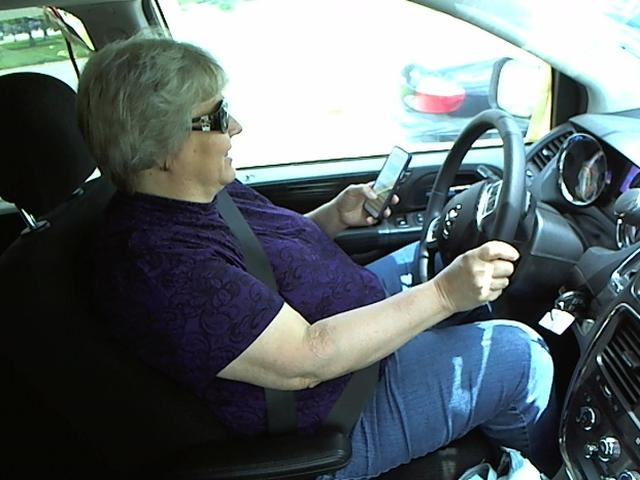

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Min Proba for cls: c9; desc: talking to passenger; proba: 0.2138; nObsNew: 1
  /Users/bbalaji-2012/Documents/Work/DataScience/Kaggle/StateFarm/data/imgs/test/img_56682.jpg:


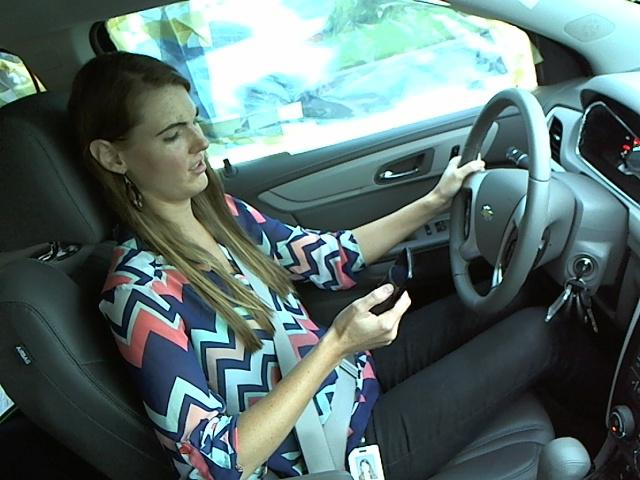

  Proba:
[ 0.0001  0.1191  0.1549  0.054   0.2004  0.      0.1031  0.      0.1546
  0.2138]
  next best class: talking on the phone - left


In [156]:
for clsIx, cls in enumerate(glbRspClass):
    clsMsk = glbObsNewRspPred == clsIx
    clsObsNewRspPredProba = glbObsNewRspPredProba[clsMsk, :]
    clsObsNewIdn = [glbObsNewIdn[ixMsk] for ixMsk in xrange(len(glbObsNewIdn)) \
                    if clsMsk[ixMsk]]
    print '\n'
    
    maxClsProba = np.max(clsObsNewRspPredProba[:, clsIx])
    maxObsNewRspPredProba = clsObsNewRspPredProba[:, clsIx] == maxClsProba
    print 'Max Proba for cls: %s; desc: %s; proba: %0.4f; nObsNew: %d' % \
        (cls, glbRspClassDesc[cls], maxClsProba, maxObsNewRspPredProba.sum())
    imgFilePth = os.getcwd() + '/data/' + glbDataFile['newFoldersPth'] + '/' + \
                    clsObsNewIdn[np.argmax(clsObsNewRspPredProba[:, clsIx])]
    print '  %s:' % imgFilePth
    jpgfile = Image(imgFilePth, format = 'jpg', 
                        width = glbImg['size'] * 4, height = glbImg['size'] * 4)
    display(jpgfile)         
    print '  Proba:'; 
    print np.array_str(clsObsNewRspPredProba[np.argmax(clsObsNewRspPredProba[:, clsIx]), :],
                       precision=4, suppress_small=True)
        
    minClsProba = np.min(clsObsNewRspPredProba[:, clsIx])
    minObsNewRspPredProba = clsObsNewRspPredProba[:, clsIx] == minClsProba
    print 'Min Proba for cls: %s; desc: %s; proba: %0.4f; nObsNew: %d' % \
        (cls, glbRspClassDesc[cls], minClsProba, minObsNewRspPredProba.sum())
    imgFilePth = os.getcwd() + '/data/' + glbDataFile['newFoldersPth'] + '/' + \
                    clsObsNewIdn[np.argmin(clsObsNewRspPredProba[:, clsIx])]
    print '  %s:' % imgFilePth
    jpgfile = Image(imgFilePth, format = 'jpg', 
                        width = glbImg['size'] * 4, height = glbImg['size'] * 4)
    display(jpgfile)
    print '  Proba:'; 
    print np.array_str(clsObsNewRspPredProba[np.argmin(clsObsNewRspPredProba[:, clsIx]), :],
                       precision=4, suppress_small=True)
    thsObsNewRspPredProba = clsObsNewRspPredProba[np.argmin(clsObsNewRspPredProba[:, clsIx]), :]
    thsObsNewRspPredProba[clsIx] = 0
    print '  next best class: %s' % \
        (glbRspClassDesc[glbRspClass[np.argmax(thsObsNewRspPredProba)]])

## Output submission

In [157]:
sbmObsNewDf = pd.DataFrame(glbObsNewRspPredProba)
sbmObsNewDf.columns = glbRspClass
sbmObsNewDf['img'] = glbObsNewIdn
sbmObsNewDf = (sbmObsNewDf
                .set_index(['img'], 
                           drop = False)
                .sort_values('img')
                )
sbmObsNewDf = sbmObsNewDf[['img'] + glbRspClass]
print sbmObsNewDf.head()
print sbmObsNewDf.tail()

                           img            c0            c1            c2  \
img                                                                        
img_1.jpg            img_1.jpg  3.072738e-10  2.049213e-14  7.323578e-07   
img_10.jpg          img_10.jpg  1.556752e-06  3.022229e-06  1.234693e-04   
img_100.jpg        img_100.jpg  8.573953e-01  1.709201e-04  1.342362e-06   
img_1000.jpg      img_1000.jpg  1.738817e-02  1.633144e-02  7.385671e-02   
img_100000.jpg  img_100000.jpg  9.468488e-07  2.942739e-07  3.135682e-07   

                          c3            c4            c5            c6  \
img                                                                      
img_1.jpg       1.930380e-15  9.624715e-11  9.999985e-01  7.862217e-07   
img_10.jpg      2.835854e-01  1.088483e-04  7.161720e-01  6.477157e-10   
img_100.jpg     2.617374e-04  9.707632e-05  2.106247e-07  1.081774e-06   
img_1000.jpg    3.573136e-07  7.267617e-01  2.487464e-05  1.641497e-01   
img_100000.jpg  3.39340

In [158]:
sbmObsNewDf.to_csv('img_04_fit_lgtRgrSGDTf_SFDD_sbmt.csv', index = False)

In [159]:
print 'LeaderBoard metric for this submission:%0.5f' % (4.24100)
print 'Best score yet:%s :%0.5f' % \
    ('img_02_fit_lgtRgr_SFDD_sbmt.csv', 2.63892)

LeaderBoard metric for this submission:4.24100
Best score yet:img_02_fit_lgtRgr_SFDD_sbmt.csv :2.63892


## Stop here

Following code should be in img_05_fit_MLPRELUSGDTf_<projectId>

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy_score.

---

In [10]:
nRELUs = [2 ** thsRelu for thsRelu in xrange(11)]
print(nRELUs)
for thsRelu in nRELUs:
    models.ix[thsRelu, 'nRELUs'] = thsRelu

print models

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1          NaN          NaN   
2          2          NaN          NaN   
4          4          NaN          NaN   
8          8          NaN          NaN   
16        16          NaN          NaN   
32        32          NaN          NaN   
64        64          NaN          NaN   
128      128          NaN          NaN   
256      256          NaN          NaN   
512      512          NaN          NaN   
1024    1024          NaN          NaN   

                                                  graph  
0     <tensorflow.python.framework.ops.Graph object ...  
1                                                   NaN  
2                                                   NaN  
4                                                   NaN  
8                                                   NaN  
16                                                  NaN  
3

In [49]:
thsRelu = nRELUs[9]
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbObsVldFtr)
  tfwObsNewFtr = tf.constant(glbObsNewFtr)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], thsRelu]), name = 'weights1')
  biases1 = tf.Variable(tf.zeros([thsRelu]), name = 'biases1')
  weights2 = tf.Variable(
    tf.truncated_normal([thsRelu, glbRspClassN]), name = 'weights2')
  biases2 = tf.Variable(tf.zeros([glbRspClassN]), name = 'biases2')
  print(weights1.initialized_value())
  print(biases1.initialized_value())
  #print(relus.initialized_value())
  print(weights2.initialized_value())
  print(biases2.initialized_value())
  #tf.Print(relus, [relus])  
     
  # Training computation.
  layer1 = tf.matmul(tfwObsFitFtr, weights1) + biases1
  layer2 = tf.nn.relu(layer1)
  layer3 = tf.matmul(layer2, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(layer3, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(layer3)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsVldFtr, weights1) + biases1), weights2) + biases2)
  tfwObsNewPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsNewFtr, weights1) + biases1), weights2) + biases2)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(512)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(512)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(512), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)


In [50]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbObsFitRsp.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbObsFitFtr[offset:(offset + batch_size), :]
    batch_labels = glbObsFitRsp[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbObsVldRsp))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbObsNewRsp))
  models.ix[thsRelu, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbObsVldRsp)
  models.ix[thsRelu, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbObsNewRsp)
  models.ix[thsRelu, 'graph'] = graph
  print(models)

Initialized
Minibatch loss at step 0: 235.251495
Minibatch accuracy: 14.1%
Validation accuracy: 23.9%
Minibatch loss at step 500: 15.635325
Minibatch accuracy: 72.7%
Validation accuracy: 77.7%
Minibatch loss at step 1000: 5.719280
Minibatch accuracy: 83.6%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 3.931793
Minibatch accuracy: 76.6%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 3.211185
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 2500: 1.988469
Minibatch accuracy: 80.5%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 3.435107
Minibatch accuracy: 77.3%
Validation accuracy: 79.1%
Test accuracy: 86.7%
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1        19.29    19.750053   
2          2        36.26    40.087588   
4          4        64.67    71.122623   
8          8        75.80    82.861568   
16        16        79.74    86.685537   
32        32        76.77    84.28754

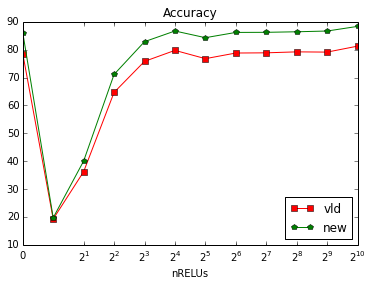

In [52]:
plt.figure()
#plt.plot(models['nRELUs'], models['accuracy_score.fit'], 'bo-', label = 'fit')
plt.plot(models['nRELUs'], models['accuracy_scoreVld'], 'rs-', label = 'vld')
plt.plot(models['nRELUs'], models['accuracy_scoreTst'], 'gp-', label = 'new')
plt.legend(loc = 'lower right')
plt.title("accuracy_score")
plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('nRELUs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()